# Deep Learning: PMC MedVQA
Muhammad Talal Faiz |
Taha Ahmad

# Importing Dataset

In [ ]:
import pandas as pd

In [ ]:

!wget "https://huggingface.co/datasets/xmcmic/PMC-VQA/resolve/main/train.csv?download=true"
!wget "https://huggingface.co/datasets/xmcmic/PMC-VQA/resolve/main/test.csv?download=true"
!wget "https://huggingface.co/datasets/xmcmic/PMC-VQA/resolve/main/test_clean.csv?download=true"
!wget "https://huggingface.co/datasets/xmcmic/PMC-VQA/resolve/main/images.zip?download=true"

--2024-05-21 00:34:53--  https://huggingface.co/datasets/xmcmic/PMC-VQA/resolve/main/train.csv?download=true
Resolving huggingface.co (huggingface.co)... 18.239.50.16, 18.239.50.49, 18.239.50.80, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.16|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/65/f8/65f80daec62edb351d171322105968e064928ce60b805f2b92635463aa43b48f/24b4e287546bbfc96ce47aadda59f43fe948b15b82820ac533363e51c1adc029?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27train.csv%3B+filename%3D%22train.csv%22%3B&response-content-type=text%2Fcsv&Expires=1716510893&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNjUxMDg5M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy82NS9mOC82NWY4MGRhZWM2MmVkYjM1MWQxNzEzMjIxMDU5NjhlMDY0OTI4Y2U2MGI4MDVmMmI5MjYzNTQ2M2FhNDNiNDhmLzI0YjRlMjg3NTQ2YmJmYzk2Y2U0N2FhZGRhNTlmNDNmZTk0OGIxNWI4MjgyMGFjN

# Extracting Dataset

In [ ]:
!unzip "/content/images.zip?download=true"

Streaming output truncated to the last 5000 lines.
  inflating: images/PMC7874794_j_biol-2019-0035_fig_006.jpg  
  inflating: images/PMC6148031_Fig1.jpg  
  inflating: images/PMC9378323_Fig1.jpg  
  inflating: images/PMC2396155_F2.jpg  
  inflating: images/PMC4093318_F3.jpg  
  inflating: images/PMC8569400_fig0002.jpg  
  inflating: images/PMC8612748_FIG1.jpg  
  inflating: images/PMC4049769_f1-ol-07-06-1847.jpg  
  inflating: images/PMC2734526_F1.jpg  
  inflating: images/PMC3498183_pone-0050122-g002.jpg  
  inflating: images/PMC8908603_Fig6.jpg  
  inflating: images/PMC8363778_FIG3.jpg  
  inflating: images/PMC5310572_Fig10.jpg  
  inflating: images/PMC8501738_Fig2.jpg  
  inflating: images/PMC4956622_Fig5.jpg  
  inflating: images/PMC3585969_pone-0057583-g002.jpg  
  inflating: images/PMC7570024_jcdd-07-00030-f019.jpg  
  inflating: images/PMC6477770_fig3-1756286419840593.jpg  
  inflating: images/PMC4786376_FIG1.jpg  
  inflating: images/PMC8917295_f0010.jpg  
  inflating: images/P

In [ ]:
rm "/content/images.zip?download=true"

# Exploring Dataset

In [ ]:
import pandas as pd
train=pd.read_csv("/content/train.csv?download=true")
train.head()

nan_values = train.isna().sum()

# Display the NaN values
print("NaN values in the dataset:")
print(nan_values)
train_cleaned = train.dropna()
print(train_cleaned.isna().sum())
train_sampled = train_cleaned.sample(n=6400, random_state=42)
train_sampled.to_csv("/content/train_cleaned.csv?download=true", index=False)

NaN values in the dataset:
Figure_path      0
Question         0
Answer          75
Choice A         0
Choice B         0
Choice C         0
Choice D         0
Answer_label     0
dtype: int64
Figure_path     0
Question        0
Answer          0
Choice A        0
Choice B        0
Choice C        0
Choice D        0
Answer_label    0
dtype: int64


# Preparing Dataset

In [ ]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, BertTokenizer, BertForMaskedLM
import torch
import torch.nn as nn
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
class MedVQADataset(Dataset):
    def __init__(self, csv_file, image_dir, clip_processor):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.clip_processor=clip_processor
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = f"{self.image_dir}/{row['Figure_path']}"
        question = row['Question']
        answer = row['Answer']

        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        image = self.clip_processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

        return image, question, answer



train_dataset = MedVQADataset(
    csv_file='/content/train_cleaned.csv?download=true',
    image_dir='/content/images',
    clip_processor=clip_processor
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

FileNotFoundError: [Errno 2] No such file or directory: '/content/train_cleaned.csv?download=true'

# Model Architecture

In [ ]:
import torch
import torch.nn as nn
from transformers import CLIPProcessor, CLIPModel, BertTokenizer, BertForMaskedLM
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
class MedVQAModel(nn.Module):
    def __init__(self, clip_model, clip_processor, bert_model,tokenizer):
        super(MedVQAModel, self).__init__()
        self.clip_model = clip_model
        self.clip_processor = clip_processor
        self.bert_model = bert_model
        self.tokenizer=tokenizer

        self.visual_projection = nn.Sequential(
            nn.Linear(512, bert_model.config.hidden_size),
            nn.ReLU(),
            nn.Linear(bert_model.config.hidden_size, bert_model.config.hidden_size)
        )
        self.text_projection = nn.Sequential(
            nn.Linear(512, bert_model.config.hidden_size),
            nn.ReLU(),
            nn.Linear(bert_model.config.hidden_size, bert_model.config.hidden_size)
        )

        d_model = bert_model.config.hidden_size * 2
        self.multimodal_decoder = nn.Transformer(
            d_model=d_model,
            nhead=8,
            num_encoder_layers=4,
            num_decoder_layers=4,
            dim_feedforward=2048
        )

    def forward(self, images, questions,answer, is_multiple_choice=False, options=None):
        batch_size = images.size(0)


        image_inputs = {'pixel_values': images}
        image_features = self.clip_model.get_image_featues(**image_inputs)


        text_inputs = self.clip_processor(text=questions, return_tensors="pt", padding=True, truncation=True)
        text_features = self.clip_model.get_text_features(**text_inputs)


        image_features = self.visual_projection(image_features)
        text_features = self.text_projection(text_features)

        combined_features = torch.cat((image_features, text_features), dim=-1)
        combined_features = combined_features.unsqueeze(0)  # Adding sequence dimension


        prompt = [f"Question: {question}, the answer is: [MASK]" for question in questions]

        inputs_bert = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
        decoder_input = self.tokenizer("[MASK]", return_tensors="pt",add_special_tokens=False).input_ids.repeat(batch_size, 1)

        decoder_input = decoder_input.unsqueeze(0)


        combined_features = combined_features.permute(1, 0, 2)
        decoder_input = decoder_input.permute(1, 0, 2)
        # (32,1,3)
        combined_features=combined_features.float()
        decoder_input=decoder_input.expand(-1, -1, 1536)
        decoder_input=decoder_input.float()

        bert_outputs = self.multimodal_decoder(
            src=combined_features,
            tgt=decoder_input
        )

        # Decode the output to get the answer
        output_ids = torch.argmax(bert_outputs, dim=-1)

        answers = [self.tokenizer.decode(output_id, skip_special_tokens=True) for output_id in output_ids.squeeze()]
        answers=answer

        return answers

# Loss function
loss_function = nn.CrossEntropyLoss()


clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
bert_model = BertForMaskedLM.from_pretrained("bert-base-uncased")
medvqa_model = MedVQAModel(clip_model, clip_processor, bert_model,tokenizer)

optimizer_pm = torch.optim.Adam([
    {"params": medvqa_model.bert_model.parameters()},
    {"params": medvqa_model.clip_model.parameters()}
], lr=0.0001)
optimizer_decoder = torch.optim.Adam(medvqa_model.multimodal_decoder.parameters(), lr=0.001)



# Model Training Script

In [ ]:

import os
import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

def train_model(model, train_loader, optimizer_pm, optimizer_decoder, loss_function, num_epochs, save_dir):
    model.train()


    writer = SummaryWriter()

    for epoch in range(num_epochs):
        total_loss = 0.0

        for batch_idx, (images, questions, ground_truth_answers) in enumerate(train_loader):
            optimizer_pm.zero_grad()
            optimizer_decoder.zero_grad()

            # Generate answers
            predicted_answers = model(images, questions)

            #
            all_predicted_token_ids = []
            all_ground_truth_token_ids = []

            for predicted_answer, ground_truth_answer in zip(predicted_answers, ground_truth_answers):

                predicted_token_ids = tokenizer.encode(predicted_answer, add_special_tokens=False)
                ground_truth_token_ids = tokenizer.encode(ground_truth_answer, add_special_tokens=False)


                all_predicted_token_ids.append(predicted_token_ids)
                all_ground_truth_token_ids.append(ground_truth_token_ids)


            max_predicted_length = max(len(ids) for ids in all_predicted_token_ids)
            max_ground_truth_length = max(len(ids) for ids in all_ground_truth_token_ids)


            padded_predicted_token_ids = [ids[:max_ground_truth_length] + [tokenizer.pad_token_id] * (max_ground_truth_length - len(ids[:max_ground_truth_length])) for ids in all_predicted_token_ids]
            padded_ground_truth_token_ids = [ids + [tokenizer.pad_token_id] * (max_ground_truth_length - len(ids)) for ids in all_ground_truth_token_ids]


            predicted_token_ids_tensor = torch.tensor(padded_predicted_token_ids, dtype=torch.long)
            ground_truth_token_ids_tensor = torch.tensor(padded_ground_truth_token_ids, dtype=torch.long)


            predicted_logits = F.log_softmax(predicted_token_ids_tensor.float(), dim=-1)


            predicted_logits = predicted_logits.view(-1, predicted_logits.size(-1))


            ground_truth_token_ids_flat = ground_truth_token_ids_tensor.view(-1).float().requires_grad_()

            # Calculate loss
            predicted_logits_flat = predicted_logits.view(-1).requires_grad_()
            loss = loss_function(predicted_logits_flat, ground_truth_token_ids_flat)
            total_loss += loss.item()

            # Backpropagation
            loss.backward()
            optimizer_pm.step()
            optimizer_decoder.step()


            writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + batch_idx)


            print(f"\rEpoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}", end='')


        avg_loss = total_loss / len(train_loader)
        print(f"\nEpoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")


        save_path = os.path.join(save_dir, f'model_epoch_{epoch + 1}.pt')
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")


    writer.close()

save_dir = '/content/Model'

# Call the training function
train_model(medvqa_model, train_loader, optimizer_pm, optimizer_decoder, nn.CrossEntropyLoss(), 5, save_dir)


Epoch 1/5, Batch 200/200, Loss: 471268032.0000
Epoch 1/5, Average Loss: 662295681.2800
Model saved to /content/Model/model_epoch_1.pt
Epoch 2/5, Batch 200/200, Loss: 755597696.0000
Epoch 2/5, Average Loss: 628063245.9200
Model saved to /content/Model/model_epoch_2.pt
Epoch 3/5, Batch 200/200, Loss: 712631104.0000
Epoch 3/5, Average Loss: 660478816.4800
Model saved to /content/Model/model_epoch_3.pt
Epoch 4/5, Batch 200/200, Loss: 378408256.0000
Epoch 4/5, Average Loss: 647147007.7200
Model saved to /content/Model/model_epoch_4.pt
Epoch 5/5, Batch 200/200, Loss: 688511552.0000
Epoch 5/5, Average Loss: 649551454.8800
Model saved to /content/Model/model_epoch_5.pt


# Sample Results

The Question is: Is/Are there a Pleural effusion?
The answer is: Actual: No predicted value: yes
**************************************************


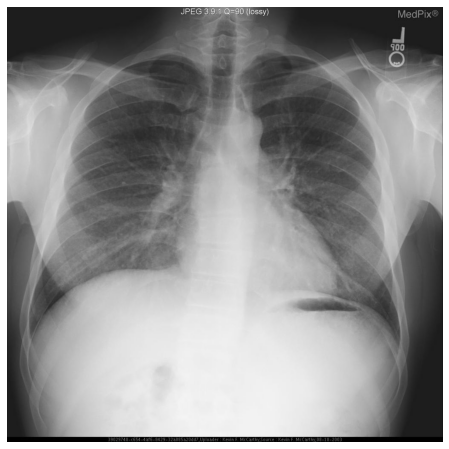

The Question is: Is a pleural effusion present?
The answer is: Actual: No predicted value: yes
**************************************************


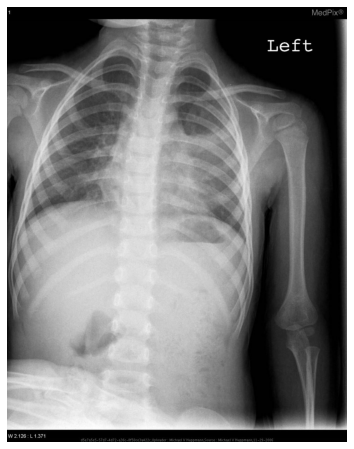

The Question is: Is there a pleural effusion?
The answer is: Actual: No predicted value: no
**************************************************


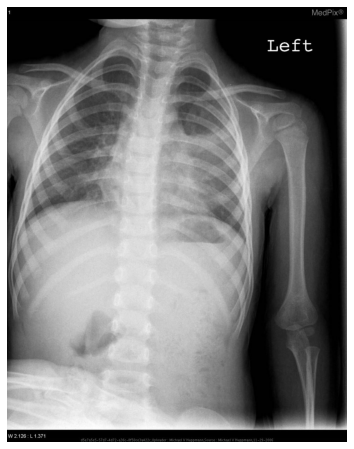

The Question is: Is the heart size abnormal?
The answer is: Actual: No predicted value: no
**************************************************


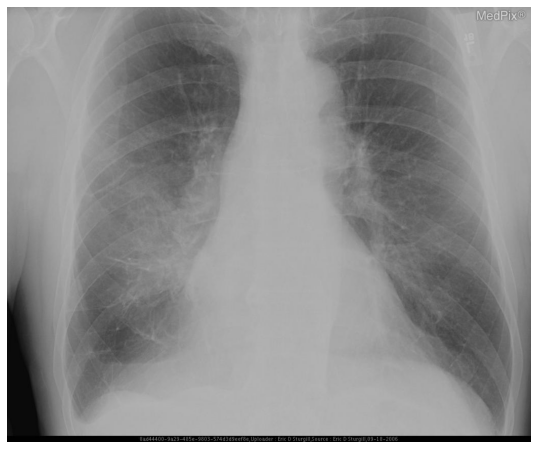

The Question is: Is the heart enlarged?
The answer is: Actual: No predicted value: no
**************************************************


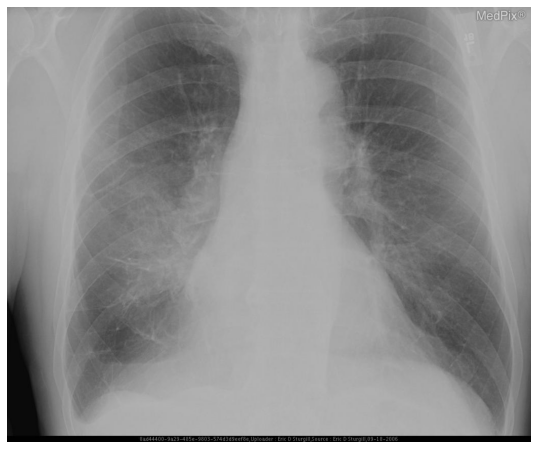

In [ ]:
import pickle
x = open('/content/drive/MyDrive/cache/trainval_label2ans.pkl','rb')
a2lab = pickle.load(x)
import cv2
img_path = '/content/drive/MyDrive/VQA_RAD Image Folder/'
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(760,770,2):
  plt.figure(figsize=(10,8))
  image = cv2.imread(img_path+ train[i]['image_name'])
  plt.imshow(image)
  value = "Actual: "+str(train[i]['answer'])+' predicted value: '+ str(a2lab[medvqa_model(image,train[i]['question'])])
  plt.axis('off')
  print("The Question is:",train[i]['question'])
  print("The answer is:",value)
  print("*"*50)
  plt.show()